# Scaling XGBoost with Dask and Coiled

This notebook walks through training an [XGBoost](https://xgboost.readthedocs.io/en/latest/) model locally on a small dataset and then using [Dask](https://dask.org/) and [Coiled](https://coiled.io/) to scale out to the cloud and run XGBoost on a larger-than-memory dataset.

# Local XGBoost

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a popular library for training gradient boosted supervised machine learning models. 

## Load our dataset

The first step towards training our model is to load our dataset. We'll use the [Higgs dataset](https://archive.ics.uci.edu/ml/datasets/HIGGS), which is available on Amazon S3. The dataset is composed of 11 million simulated particle collisions, each of which is described by 28 real-valued, features and a binary label indicating which class the sample belongs to (i.e. whether the sample represents a signal or background event). To start, we'll load only a sample of the dataset (just over 175 thousand samples) and process the full datset in the next section.

In [1]:
import pandas as pd

# Load a single CSV file
df = pd.read_csv("s3://coiled-data/higgs/higgs-00.csv")
df

,labels,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b-tag,...,jet_4_eta,jet_4_phi,jet_4_b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175216,1,0.556165,-1.221411,1.382576,0.485715,-1.048621,1.108081,-0.118853,1.646101,2.173076,...,1.265431,0.291167,0.000000,1.263402,1.034347,0.986912,0.733762,0.899887,1.118665,0.932763
175217,0,0.868561,-0.473403,0.530864,2.481327,0.981628,0.547078,-0.971441,-1.570490,0.000000,...,0.031187,-0.304356,1.550981,1.298022,0.841658,0.992392,1.120417,0.207082,0.781515,0.877750
175218,1,0.630832,-1.620738,-0.082360,0.866506,-1.247463,0.568423,-0.256495,-1.292748,2.173076,...,-2.413150,1.378795,0.000000,0.628195,0.764134,0.985883,0.711534,0.843467,0.805140,0.720537
175219,1,0.904980,-1.086029,-0.274342,1.158548,-1.258253,0.515474,-1.929983,0.133211,0.000000,...,0.377641,1.184021,0.000000,0.880999,0.949600,1.098452,0.930461,0.781536,0.818147,0.779077


Next, we can separate our classification label and training features and then use Scikit-learn's `sklearn.model_selection.train_test_split` function to partition the dataset into training and testing samples.

In [2]:
X, y = df.iloc[:, 1:], df["labels"]

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

To use XGBoost, we'll need to construct `xgboost.DMatrix` objects for both our training and testing datasets -- these are the internal data structures XGBoost uses to manage dataset features and targets. However, since XGBoost plays well with libaries like NumPy and Pandas, we can simply pass our training and testing datasets directly to `xgboost.DMatrix(...)`.

In [4]:
import xgboost

dtrain = xgboost.DMatrix(X_train, y_train)
dtest = xgboost.DMatrix(X_test, y_test)

Next we'll define the set of hyperparameters we want to use for our XGBoost model and train the model!

In [5]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'min_child_weight': 0.5,
}

bst = xgboost.train(params, dtrain, num_boost_round=3)

[19:50:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1635105055642/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Now that our model has been trained, we can use it to make predictions on the testing dataset which was _not_ used to train the model.

In [6]:
y_pred = bst.predict(dtest)

y_pred

array([0.35453397, 0.37292427, 0.6248538 , ..., 0.5387489 , 0.42110202,
       0.466944  ], dtype=float32)

To get a sense for the quality of these predictions we can compute and plot a [receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) of our model's predictions, which compares the predicted output from our model with the known labels to calculate the true postive rate vs. false positive rate.

In [7]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred)

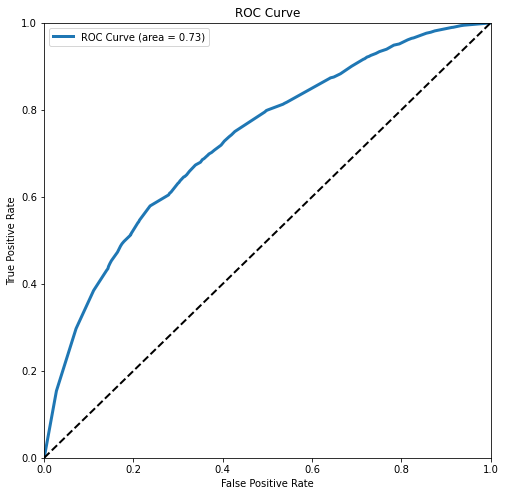

In [8]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], "k--", lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend()
plt.show()

# Scaling with Dask and Coiled

In the previous section, we trained a model with a subset of the full Higgs dataset. In this section, we will use the full dataset with 11 million samples! With this increased number of samples, the dataset may not fit comfortably into memory on a personal laptop. So we'll use Dask and Coiled to expand our compute resources to the cloud to enable us to work with this larger datset.

### Create a Dask cluster on AWS with Coiled

Let's create a Coiled cluster using the `examples/xgboost` software environment, which has Dask, XGBoost, Scikit-learn, and other relavant packages installed, and then connect a `dask.distributed.Client` to our cluster so we can begin to submit tasks to the cluster.

First, sign-in to Coiled Cloud (if you haven't already):
1. Go to [cloud.coiled.io](https://cloud.coiled.io)
2. Sign-in with GitHub, Google, or Email.
3. Copy your security token from the Profile page: https://cloud.coiled.io/profile (and paste it when asked below!)

In [9]:
import coiled

cluster = coiled.Cluster(
    n_workers=10,
    software="examples/scaling-xgboost",
)

Invalid Coiled token encountered. Typically this occurs after logging out of 
https://cloud.coiled.io which resets your token for security reasons.

Please login to https://cloud.coiled.io/profile to get your token

Token:

  ········································


Authentication successful

Save credentials for next time? [Y/n]:  n


/Users/pavithra/mambaforge/envs/xgboost-binder/lib/python3.9/site-packages/rich/live.py:227: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


Found software environment build
Created FW rules: coiled-dask-pavithr13-69522-firewall
Created scheduler VM: coiled-dask-pavithr13-69522-scheduler (type: t3a.medium, ip: ['3.92.81.243'])


In [10]:
import dask.distributed

client = dask.distributed.Client(cluster)
client

/Users/pavithra/mambaforge/envs/xgboost-binder/lib/python3.9/site-packages/distributed/client.py:1128: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| lz4     | 3.1.3  | None      | None    |
| numpy   | 1.21.4 | 1.21.3    | 1.21.3  |
| toolz   | 0.11.2 | 0.11.1    | 0.11.1  |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tls://10.4.3.242:8786' processes=10 threads=20, memory=75.60 GiB>

#### ☝️ Don’t forget to click the \"Dashboard\" link above to view the cluster dashboard!

### Load full dataset

Dask's `read_csv` functions makes it easy to read in all the CSV files in the dataset.

In [11]:
import dask.dataframe as dd

# Load the entire dataset using Dask
ddf = dd.read_csv("s3://coiled-data/higgs/higgs-*.csv", storage_options={"anon": True})
ddf

,labels,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b-tag,jet_2_pt,jet_2_eta,jet_2_phi,jet_2_b-tag,jet_3_pt,jet_3_eta,jet_3_phi,jet_3_b-tag,jet_4_pt,jet_4_eta,jet_4_phi,jet_4_b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
npartitions=126,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Dask's machine learning library, [Dask-ML](https://ml.dask.org/), mimics Scikit-learn's API, providing scalable versions of functions of `sklearn.datasets.make_classification` and `sklearn.model_selection.train_test_split` that are designed to work with Dask Arrays and DataFrames in larger-than-memory settings.

Let's use Dask-ML to generate a similar classification dataset as before, but now with 100 million samples.

In [12]:
from dask_ml.model_selection import train_test_split

X, y = ddf.iloc[:, 1:], ddf["labels"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)

Next we'll [persist our training and testing datasets](https://distributed.dask.org/en/latest/memory.html#persisting-collections) into distributed memory to avoid any unnecessary re-computations.

In [13]:
import dask

X_train, X_test, y_train, y_test = dask.persist(X_train, X_test, y_train, y_test)

X_train

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b-tag,jet_2_pt,jet_2_eta,jet_2_phi,jet_2_b-tag,jet_3_pt,jet_3_eta,jet_3_phi,jet_3_b-tag,jet_4_pt,jet_4_eta,jet_4_phi,jet_4_b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
npartitions=126,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


To do distributed training of an XGBoost model, we'll use the [Dask-XGBoost](https://github.com/dask/dask-xgboost) package which mirrors XGBoost's interface but works with Dask Arrays and DataFrames.

In [14]:
import dask_xgboost

bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=3)

Finally, we can again compute and plot the ROC curve for this model's predictions.

In [15]:
y_pred = dask_xgboost.predict(client, bst, X_test)

y_test, y_pred = dask.compute(y_test, y_pred)

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

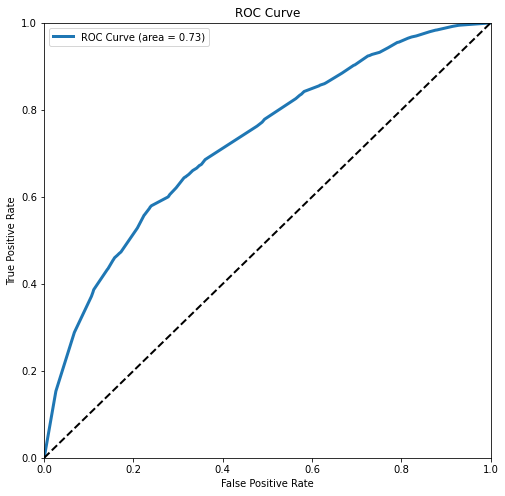

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], "k--", lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend()
plt.show()

Voilà! Congratulations on training a boosted decision tree in the cloud.

---

To run more computations like this, install Coiled locally with: `pip/conda install coiled` and check out other examples in the [coiled-resources repository](https://github.com/coiled/coiled-resources)!